In [1]:
from __future__ import print_function, division
import requests
import time
from bs4 import BeautifulSoup
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sys
from collections import defaultdict

from IPython.display import Image
%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.externals.six import StringIO
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures

In [2]:
import seaborn as sns

%matplotlib inline

from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LinearRegression, Lasso, LassoCV

/Users/yanxilu/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
#original DataFrame
df_rank = pd.read_html('tables.html')[0]
df_rank["Name"] = df_rank["Name"].str.replace("United StatesExplore","")

In [5]:
school_list = list(df_rank["Name"].values)
for i,school in enumerate(school_list):
    if "," in school:
        replace_word = school.replace(",","")
        school_list[i] = replace_word
        if " " in replace_word:
            school_list[i] = replace_word.replace(" ","-")
    elif " " in school:
        school_list[i] = school.replace(" ","-")
    if "&" in school:
        replace_word = school.replace("&","")
        replace_word_2 = replace_word.replace("--","-")
        school_list[i] = replace_word_2.replace(" ","-")

In [6]:
list_sch = []
for i,item in enumerate(school_list):
    if "-" in item:
        replaced = item.replace("-"," ")
        list_sch.append(replaced)
df_rank["Name"] = list_sch

In [7]:
# add information including student number, ratio,etc
new_url_list = []
import codecs
f=codecs.open("tables.html", 'r')
soup4 = BeautifulSoup(f, "lxml")
links = []
for link in soup4.findAll('a'):
    links.append(link.get('href'))
for part_ulr in links[50:364]:
    new_url = "https://www.timeshighereducation.com" + part_ulr
    new_url_list.append(new_url)

In [8]:
listn_dicti = defaultdict()
listn_dicti2 = defaultdict()
for i,url in enumerate(new_url_list[::2]):
    try:
        response_test = requests.get(url)
        page_test = response_test.text
        soup_test= BeautifulSoup(page_test, "lxml")
        listn = [rows.get_text() for rows in soup_test.find_all("div", class_="value")]
        listn_dicti[school_list[i]] = listn
    except:
        print("url")

In [9]:
#orgainzing the stats retrived above
for key, value in listn_dicti.items():
    if "-" in key:
        replace_key =key.replace("-", " ")
        listn_dicti[replace_key] = listn_dicti.pop(key)
numberstudent = defaultdict()
fm_ratio = defaultdict()
f_to_s = defaultdict()
intera_r = defaultdict()
for key, value in listn_dicti.items():
    for number in value:
        if "%" in number:
            intera_r[key] = number
        elif ":" in number:
            fm_ratio[key] = number
        elif "." in number:
            f_to_s[key] = number
        elif number!=float and "$"not in number: 
            numberstudent[key] = number 

In [11]:
Name_list = list(listn_dicti.keys())
for i,item in enumerate(Name_list):
    if "-" in item:
        Name_list[i] = item.replace("-"," ")

In [12]:
#first time of merging!!
df3 = pd.DataFrame()
df3["Name"] = Name_list
df3["f_to_s"] = list(f_to_s.values())
df3["intera_r"] = list(intera_r.values())
df3["numberstudent"] = list(numberstudent.values())
dfm1 = pd.merge(df3, df_rank, on='Name',how='outer')

In [15]:
# add information including tuition and salary
file = open("tuition.txt","r")
contents = []
for line in file:
    contents.append(line)
tuition = []
salary = []
uni_n_l = []
count = 0
for j,line in enumerate(contents):
    if "Explore" in line:
        count +=1
        line = line.split("\t")
        tuition.append(line[1][1:])
        salary.append(line[3][1:-1])
    if "=" in line or ">" in line or line[0].isdigit():
        uni_n = ""
        for char in line:
            if char.islower() or char.isupper() or char == " ":
                uni_n += char
        uni_n_l.append(uni_n)
                
uni_n_l[0] = "Stanford University" 
tuition.insert(0, "44,757")
salary.insert(0, "83,400")
df4 = pd.DataFrame()
df4["Name"] = uni_n_l
df4["Tuition"] = tuition
df4["Salary"] = salary

In [17]:
#second merge!!
dfm2 = pd.merge(dfm1, df4, on='Name')

In [20]:
#add information of citation
path = 'Citation_n.html'
ecj_data = open(path,'r').read()
soup = BeautifulSoup(ecj_data)
tables = soup.find_all("table")
rows=[row for row in tables[0].find_all('tr')]
cit_uni_n_l = []
citation_nu = []
for row in rows[1:]:
    items = row.find_all('td')
    cit_uni_n_l.append(items[1].get_text())
    citation_nu.append(items[3].get_text())
df5=pd.DataFrame()
df5["Name"] = cit_uni_n_l
df5["Citation"] = citation_nu
list1 = list(dfm2["Name"].values)
list2 = list(df5["Name"].values)
df5 = df5.set_index("Name")

/Users/yanxilu/anaconda/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/yanxilu/anaconda/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [21]:
#for unavailable data 
for item in list1:
    if item not in list2:
        df5.loc[item] = 1000
df5 = df5.reset_index()
#third merge
dfm3 = pd.merge(dfm2, df5, on='Name')

In [22]:
# add information of nobel prize:
url6 = "https://www.nobelprize.org/nobel_prizes/lists/universities.html"
response6 = requests.get(url6)
page6 = response6.text
soup6 = BeautifulSoup(page6, "lxml")
uni_n_nb = []
uni_n_nb_num = []
for line in soup6.find_all("h3",{"style":"margin: 0; padding: 0;"}):
    data_cit = line.get_text()
    uni_n_nb.append(data_cit.split(",")[0])
    n = data_cit.split(",")[-1]
    uni_n_nb_num.append(int(re.findall(r'\(([^()]+)\)',n)[0]))
df6 = pd.DataFrame()
df6["Name"] = uni_n_nb
df6["Nobel"] = uni_n_nb_num 
df6 = df6.set_index("Name")

In [23]:
#for unavailable data 
for item in list1:
    if item not in uni_n_nb:
        df6.loc[item] = 0
df6 = df6.reset_index()
#fourth merge
dfm4 = pd.merge(dfm3, df6, on='Name')

In [24]:
#add information of endowment
url7 = "http://endowments.com/funds/"
response7 = requests.get(url7)
page7 = response7.text
soup7 = BeautifulSoup(page7, "lxml")
tables = soup7.find_all("table")
rows=[row for row in tables[0].find_all('tr')]
endo_n_l = []
endo_num_l = []
for row in rows:
    items = row.find_all('td')
    endo_n_l.append(items[0].text)
    endo_num_l.append(items[1].text[1:])

In [25]:
#organize the data
endo_num_l_list = []
for i,item in enumerate(endo_num_l[1:]):
    try:
        if not item:
            endo_num_l_list.append(item)
        else:
            if "B" in item and "$" not in item:
                number = float(item[:-1])*1000
                endo_num_l_list.append(number)
            if "M" in item:
                number = float(item[:-1])
                endo_num_l_list.append(number)
            if "$" in item:
                number = float(item[2:-1])*1000
                endo_num_l_list.append(number)
    except:
        print(item)

In [26]:
#for unavailable data:
df7 = pd.DataFrame()
df7["Name"] = endo_n_l[1:]
df7["Endow"] = endo_num_l_list
df7 = df7.set_index("Name")
for item in list1:
    if item not in endo_n_l:
        df7.loc[item] = 100
df7 = df7.reset_index()
# fifth merge
dfm5 = pd.merge(dfm4, df7, on='Name')

In [27]:
#find the location of school to retrieve GDP data
url7 = "https://www.timeshighereducation.com/student/best-universities/best-universities-united-states"
response7 = requests.get(url7)
page7 = response7.text
soup7 = BeautifulSoup(page7, "lxml")
rows=soup7.find_all("table")[0].find_all('tr')
university_n = []
state_list = []
for row in rows[1:]:
    items=row.find_all('td')
    university_n.append(items[2].text)
    state_list.append(items[3].text)
for i,item in enumerate(state_list):
    if "\xa0" in item:
        state_list[i] =item.strip()
for i,item in enumerate(university_n):
    if "," in item:
        university_n[i] = item.replace(",","")
    if "-" in item:
        university_n[i] = item.replace("-"," ")

In [94]:
# Dataframe of Location
df9 = pd.DataFrame()
df9["State"] = state_list
df9["Name"] =university_n

In [105]:
df9['State'] = df9['State'].astype(str)

In [119]:
#GDP
url8 = "https://en.wikipedia.org/wiki/List_of_U.S._states_by_GDP"
response8 = requests.get(url8)
page8 = response8.text
soup8 = BeautifulSoup(page8, "lxml")
rows=soup8.find_all("table")[0].find_all('tr')
GDP_list = []
state_list2 = []
for row in rows[1:]:
    GDP_list.append(row.text.split("\n")[4])
    state_list2.append(row.text.split("\n")[3])
for i,item in enumerate(GDP_list):
    if "," in item:
        GDP_list[i] = item.replace(",","")
GDP_list
df8=pd.DataFrame()
df8["State"] = state_list2
df8["GDP"] = GDP_list
df8['GDP'].iloc[0] = 18511499
df8['GDP'] = df8['GDP'].astype(int)

In [121]:
for key,value in df8.iterrows():
    df8['State'].iloc[key] = value['State'][1:]

/Users/yanxilu/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [124]:
#sixth merge for the tables above:
dfm7 = pd.merge(df9,df8,left_on="State",right_on ='State',how = 'inner')

In [125]:
#seventh merge to the main dataframe
dfm8 = pd.merge(dfm7, dfm5, on='Name')

In [126]:
#add information of endowment from wiki
WIKI_URL = "https://en.wikipedia.org/wiki/List_of_colleges_and_universities_in_the_United_States_by_endowment"

req = requests.get(WIKI_URL)
soup = BeautifulSoup(req.content, 'lxml')


In [127]:
table_classes = {"class": ["sortable", "plainrowheaders"]}
wikitables = soup.findAll("table", table_classes)
rows=[row for row in wikitables[0].find_all('tr')]
# for row in wikitables:
#     print(items[0])
school_name = []
endowment = []
for row in rows[1:90]:
    school_name.append((row.text.split("$")[0]).strip('\n'))
    Endowment_16 = row.text.split("$")[1]
    if Endowment_16:
        endowment.append(float(Endowment_16[:4]))
    else:
        endowment.append(1.1)
for i,item in enumerate(school_name):
    if "[" or "]" or "(" or ")" in item:
        replace_word = re.sub("[\(\[].*?[\)\]]", "", item)
    if "," in item:
        replace_word = replace_word.replace(",","")
    if "\n" :
        replace_word = replace_word.replace("\n","")
    if "System" in item:
        replace_word = replace_word.replace(" System","")
    school_name[i] = replace_word

In [128]:
Df9 = pd.DataFrame()
Df9["Name"] = school_name
Df9["Endowment"] = endowment
Df9 = Df9.set_index("Name")
for item in list1:
    if item not in school_name:
        Df9.loc[item] = 1.05
Df9 = Df9.reset_index()

In [129]:
dfm8 = pd.merge(dfm8, Df9, on='Name')

In [137]:
acc_div_df = pd.read_csv("Acc_div.csv")
acc_div_df.Acceptance.dtype

dtype('float64')

In [138]:
list1 = list(dfm8["Name"].values)
list2 = list(acc_div_df["Name"].values)
acc_div_df = acc_div_df.set_index("Name")
for item in list1:
    if item not in list2:
        acc_div_df.loc[item] = ["B",0.5]

In [139]:
acc_div_df = acc_div_df.reset_index()

In [140]:
dfm9 = pd.merge(dfm8,acc_div_df,on="Name")

In [142]:
#add public or private
url_tem = "http://www.stateuniversity.com/rank/score_rank_by_privc/{}"
links_list = []
school_list_all = []
for i in np.arange(1,26):
    links_list.append(url_tem.format(i))
    
def pripub(url):
# url = "http://www.stateuniversity.com/rank/score_rank_by_privc.html"
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page, "lxml")
    tables=soup.find_all("table")
    rows=[row for row in tables[0].find_all('tr')]
    school_list3 = []   
    for row in rows[2:]:
        items=row.find_all('td')
        school_list3.append(items[2].text)
    return school_list3 

for url in links_list:
    school_list = pripub(url)
    school_list_all += school_list

In [143]:
df11 = pd.DataFrame()
school_name_list1 = list(dfm9["Name"].values)
for item in school_name_list1:
    if item in school_list_all:
        df11[item] = [1]
    else:
        df11[item] = [0]
df11 = df11.T
df11 = df11.reset_index()
df11.columns = ["Name","Private"]

In [144]:
dfm10 = pd.merge(dfm9,df11,on="Name")

,State,Name,GDP,f_to_s,intera_r,numberstudent,Rank,Overall,Teaching,Research,...,International Outlook,Tuition,Salary,Citation,Nobel,Endow,Endowment,Diversity,Acceptance,Private
0,California,California Institute of Technology,2622731,6.5,27%,"2,209",=3,93.0,90.3,97.5,...,59.7,"43,362","75,900",1000,0,2000,2.10,A,0.09,1
1,California,Stanford University,2622731,7.5,22%,"15,845",=3,93.0,89.1,96.7,...,77.6,"44,757","83,400",1197114,18,17000,22.30,A+,0.05,1
2,California,University of California Los Angeles,2622731,9.6,17%,"39,279",15,85.7,80.7,88.1,...,59.5,"35,583","59,400",1000,0,100,1.80,B,0.50,0
3,California,University of California Berkeley,2622731,13.1,17%,"36,182",18,84.3,77.4,84.5,...,64.5,"35,850","61,700",1106930,0,100,1.58,B,0.50,0
4,California,University of California San Diego,2622731,12.8,17%,"29,633",31,78.7,62.9,79.8,...,51.9,"36,305","59,300",832647,0,100,1.05,B,0.50,0
5,California,University of California Santa Barbara,2622731,28.1,14%,"23,054",53,70.0,50.0,61.5,...,65.4,"36,743","51,700",537187,0,100,1.05,B,0.50,0
6,California,University of California Davis,2622731,13.8,10%,"37,365",=54,69.5,60.9,64.5,...,63.7,"36,774","56,700",486373,0,100,1.05,B,0.50,0
7,California,University of Southern California,2622731,12.8,23%,"38,380",66,66.8,49.8,58.4,...,63.0,"48,280","66,900",526928,2,3700,4.60,A+,0.17,1
8,California,University of California Irvine,2622731,17.0,21%,"30,419",99,60.6,43.4,44.9,...,65.2,"36,057","55,100",581402,0,100,1.05,B,0.50,0
9,California,University of California Santa Cruz,2622731,23.0,4%,"17,866",=162,54.8,31.5,35.0,...,51.6,"36,275","43,800",349887,0,100,1.05,B,0.50,0


In [146]:
list_div = list(dfm10["Diversity"].values)
for i,item in enumerate(list_div):
    if item == "B":
        list_div[i] = 0
    if item == "B+":
        list_div[i] = 1
    if item == "A-":
        list_div[i] = 3
    if item == "A":
        list_div[i] = 4
    if item == "A+":
        list_div[i] = 5
dfm10["Diversity"] = list_div

Analysis

In [148]:
#clean data
df_sample = dfm10
df_sample["Tuition"] = df_sample["Tuition"].apply(lambda x:int(x.replace(",","")))
df_sample["Salary"] = df_sample["Salary"].apply(lambda x:int(x.replace(",","")))
df_sample.groupby("Name")["Nobel"].count().sort_values()
df_sample[df_sample["Name"]=="Harvard University"]
df_sample = df_sample.drop([4,5])
smaller_df = df_sample[["GDP","f_to_s","Endowment","intera_r","numberstudent","Overall","Teaching","Citation","Salary","International Outlook","Research","Private","Acceptance","Diversity"]]
smaller_df["Overall"] = smaller_df["Overall"].apply(lambda x:x[:4])
smaller_df['f_to_s'] =smaller_df['f_to_s'].astype(str).astype(float)
smaller_df['intera_r'] =smaller_df['f_to_s'].astype(str).astype(float)
smaller_df['Overall'] =smaller_df['Overall'].astype(str).astype(float)
smaller_df['Citation'] =smaller_df['Citation'].astype(str).astype(int)
smaller_df["GDP"] = smaller_df["GDP"].astype(str).astype(int)
smaller_df["numberstudent"] = smaller_df["numberstudent"].apply(lambda x:int(x.replace(",","")))

/Users/yanxilu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/yanxilu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/yanxilu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

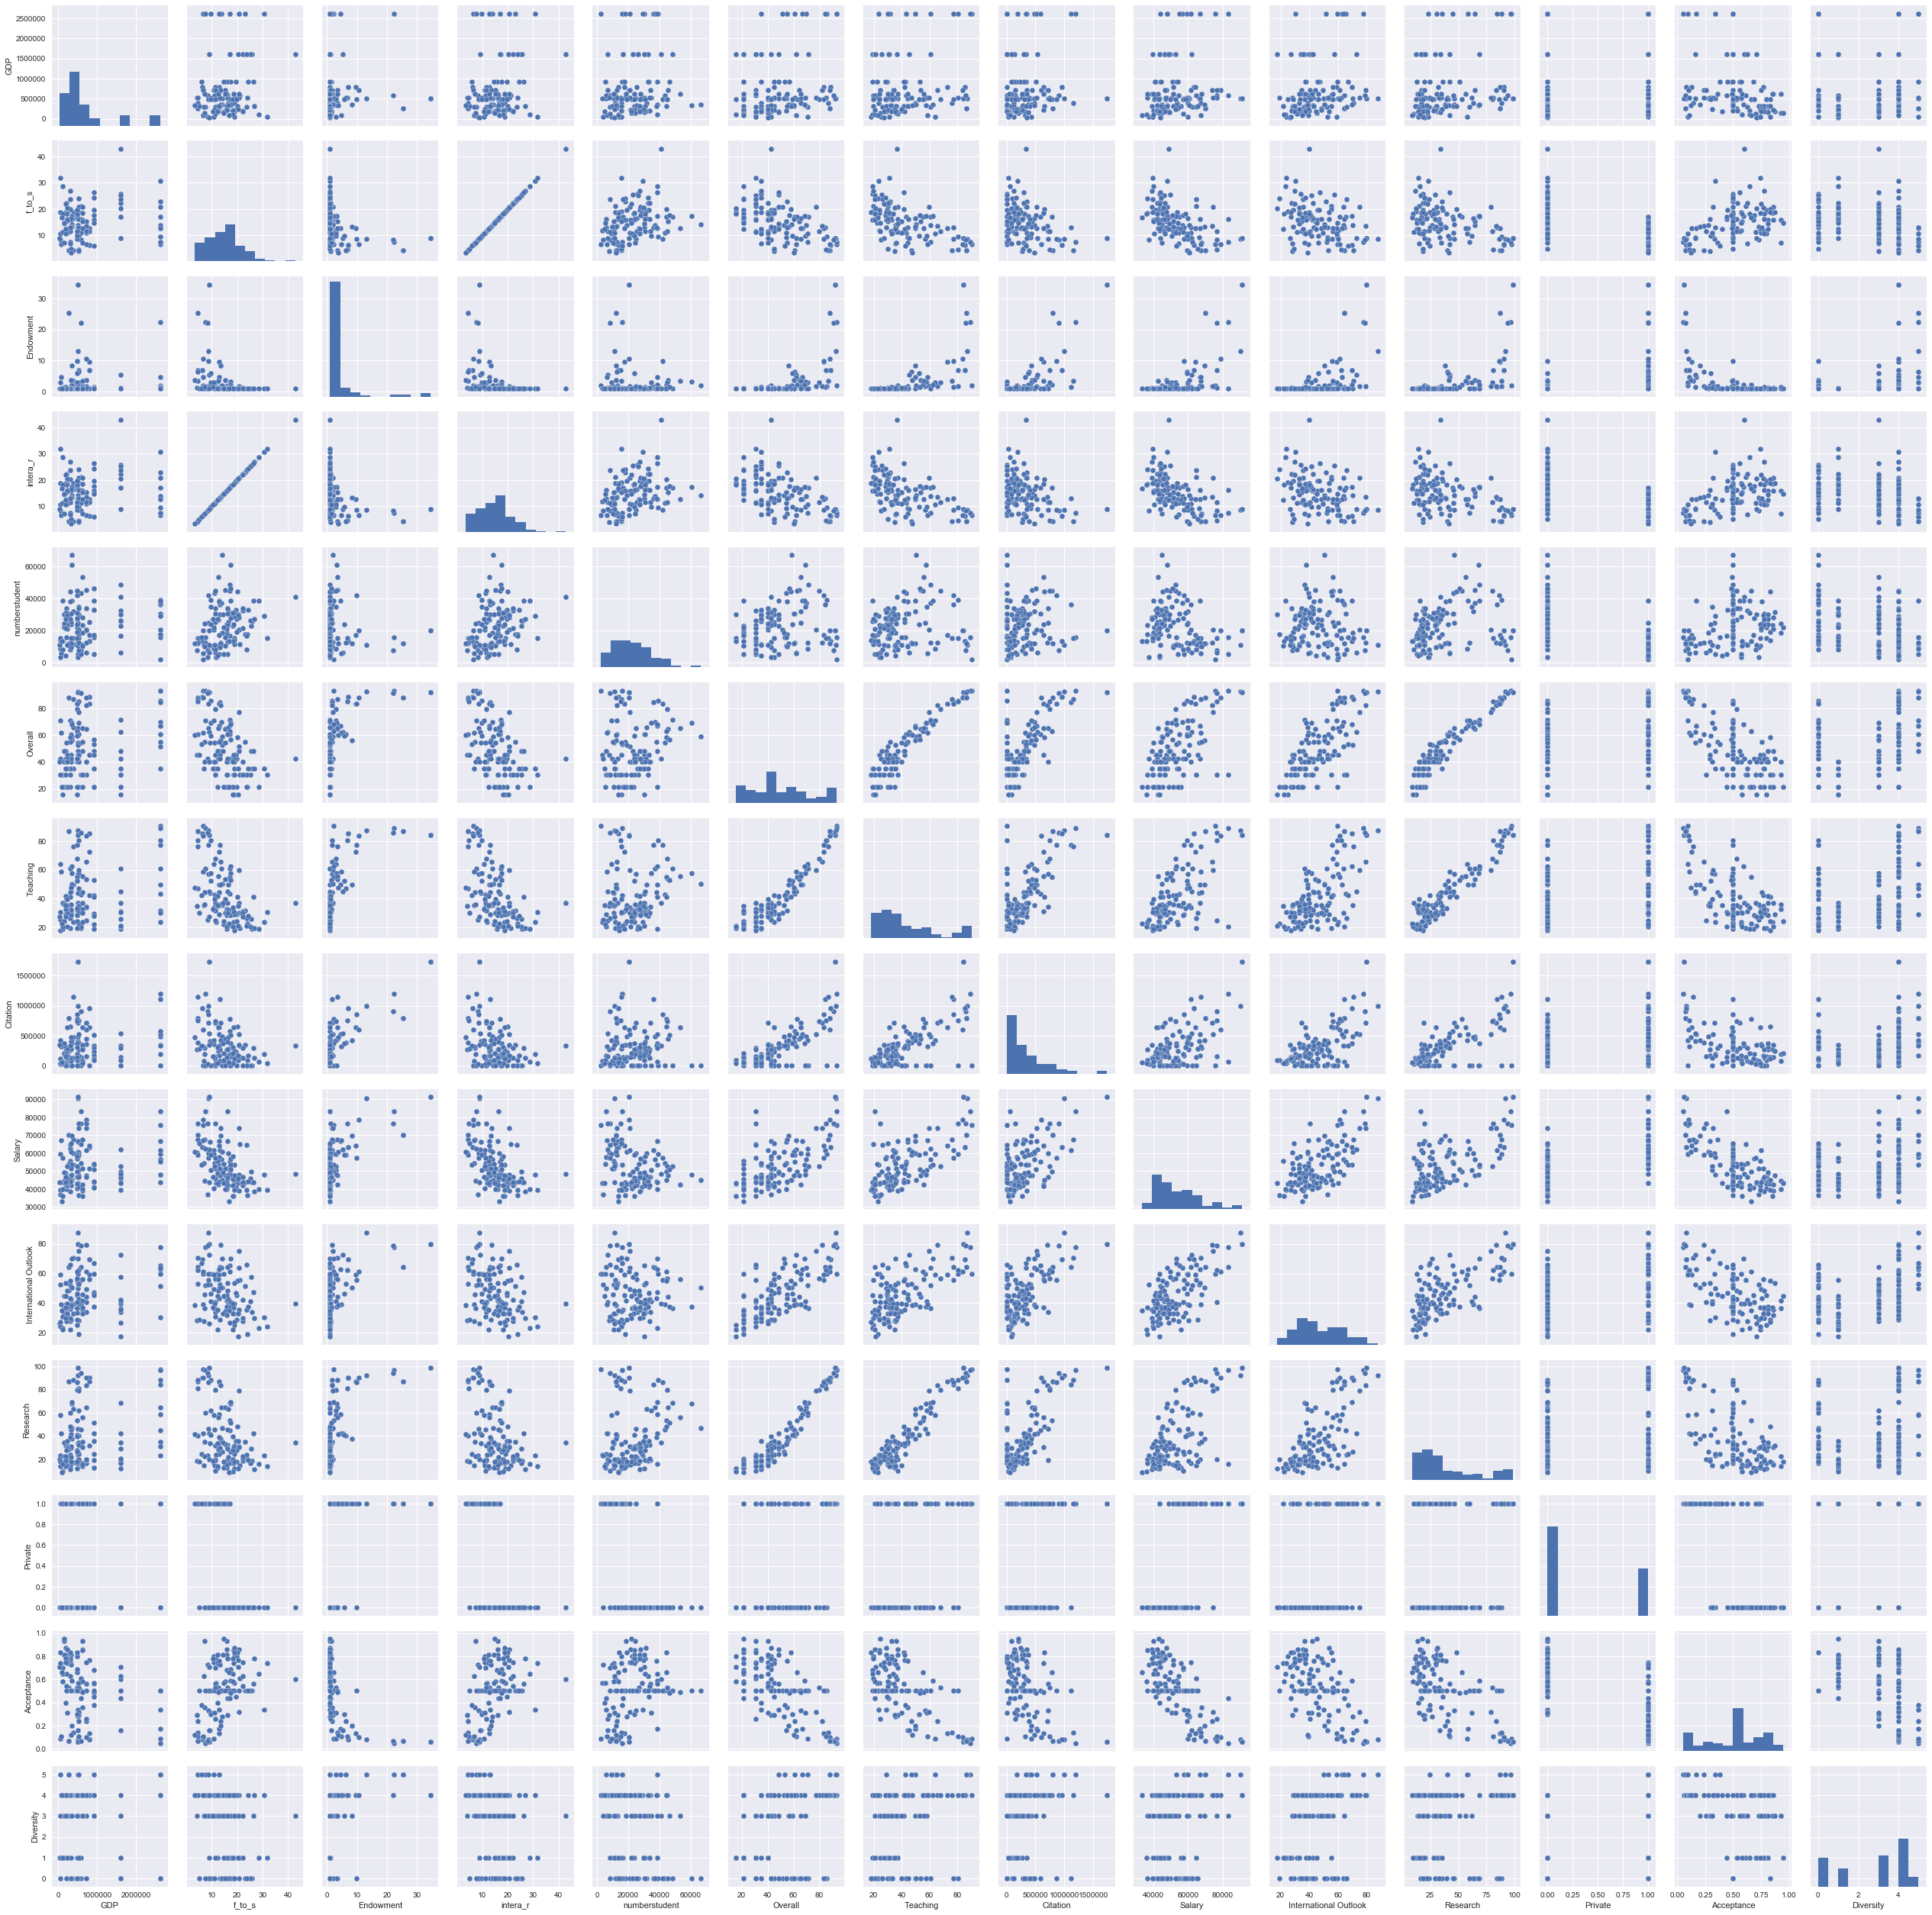

In [149]:
sns.pairplot(smaller_df)

In [200]:
smaller_df.to_pickle('Final_DataFrame')

In [151]:
#Full_model_Regression (Basic) without regularization